What this notebook does:

Applies several methods of assigning sentiment to a topic for each sentence in each review. These methods are threshold based - any topic with importance > threshold gets some of the sentiment for a sentence.  The thresholds tested are 0.2,0.4, 0.6, and 0.8.  One method ('hard') assigns the entire sentiment of the sentence to any topic greater than the threshold. Alternatively, the sentiment assigned to the topic is weighted by topic importance ('soft')

Topic importance scores for each sentence come from the 5-topic LDA model fitted on the nouns of each review ('./LDA_Fitting/LDA_onreviews_nouns_withhyptuning.ipynb')

Compound sentiments are measured using the Vader sentiment analyzer.

The threshold based LDA topic sentiments are generated for sentences from a random subset of 5000 coffee shop reviews.
The resulting feature matrix is saved in ./LDA_5topic_SentimentAssignment/comparingthresholds_reviewsent.csv'.
Features are assessed based on their ability to predict Yelp review rating in './LDA_5topic_SentimentAssignment/LDAtopicAssignment_sentences_assessment.ipynb'




In [ ]:
#Step one directory up to access the yelp scraping function in the helper_functions module
import os
print(os.getcwd())
os.chdir('../')
os.getcwd()

In [1]:
import random

import numpy as np
import pandas as pd

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en.stop_words import STOP_WORDS
#import en_core_web_sm

from tqdm import tqdm_notebook as tqdm
from pprint import pprint

from helper_functions import nlp_helpers

import pickle
from gensim.test.utils import datapath
from gensim.models import LdaModel
from gensim import corpora

import matplotlib.pyplot as plt
import seaborn as sns

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

cp thomasyoung/opt/anaconda3/envs/nlp_env/lib/python3.6/site-packages/gensim/test/test_data/lda_nounsonly_5topics.gensim.id2word thomasyoung/opt/anaconda3/envs/nlp_envp3/lib/python3.6/site-packages/gensim/test/test_data/lda_nounsonly_5topics.gensim.id2word

cp thomasyoung/opt/anaconda3/envs/nlp_env/lib/python3.6/site-packages/gensim/test/test_data/lda_nounsonly_5topics.gensim.state thomasyoung/opt/anaconda3/envs/nlp_envp3/lib/python3.6/site-packages/gensim/test/test_data/lda_nounsonly_5topics.gensim.state

cp thomasyoung/opt/anaconda3/envs/nlp_env/lib/python3.6/site-packages/gensim/test/test_data/lda_nounsonly_5topics.gensim.expElogbeta.npy thomasyoung/opt/anaconda3/envs/nlp_envp3/lib/python3.6/site-packages/gensim/test/test_data/lda_nounsonly_5topics.gensim.expElogbeta.npy

cp thomasyoung/opt/anaconda3/envs/nlp_env/lib/python3.6/site-packages/gensim/test/test_data/lda_nounsonly_5topics.gensim thomasyoung/opt/anaconda3/envs/nlp_envp3/lib/python3.6/site-packages/gensim/test/test_data/lda_nounsonly_5topics.gensim               

In [2]:
sentdf = pd.read_csv('./ProcessedData/reviewsentences_lemmatized.csv')
print(sentdf.shape)

#Only use a subset of 8000 reviews to compare different thresholds
shops = pd.read_csv('./ProcessedData/coffeeshops_withcfcutoff.csv')
reviews = pd.read_csv('./ProcessedData/lemmatizedreviews.csv')
reviews.rename(columns = {'rating':'review_rating'},inplace=True)
merged = pd.merge(shops,reviews,how='inner',on = ['alias'])

#
allrevidx = merged.reviewidx.unique().tolist()
subsetrevidx = random.sample(allrevidx,5000)
sentdf = sentdf[sentdf.reviewidx.isin(subsetrevidx)]
print(sentdf.shape)

#dropnan
sentdf = sentdf.dropna(axis=0)
print(sentdf.shape)

#rest index
sentdf.reset_index(inplace=True, drop = True)

(244523, 3)
(26371, 3)
(26358, 3)


In [3]:
#Loading the previously trained LDA model

dictionary = gensim.corpora.Dictionary.load('dictionary_allreviews_nouns.gensim')
corpus = pickle.load(open('corpus_allreviews_nouns.pkl', 'rb'))

temp_file = datapath("lda_nounsonly_5topics.gensim")
lda = gensim.models.ldamodel.LdaModel.load(temp_file)


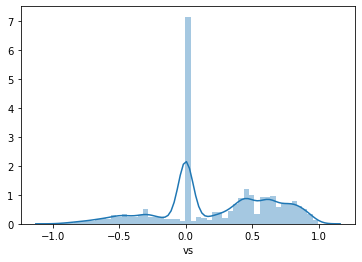

In [4]:
#Vader Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()

#Getting sentiments
vs = [analyzer.polarity_scores(sentence)['compound'] for sentence in sentdf.sentence]
sentdf['vs'] = pd.Series(vs)
sns.distplot(sentdf['vs'])

In [5]:
ldavecs = nlp_helpers.getldavec(sentdf.lemsentence.tolist(),dictionary,lda)
ldavdf = pd.DataFrame(ldavecs,columns = ['t0','t1','t2','t3','t4'])
ldavdf.head(10)

,t0,t1,t2,t3,t4
0,0.186482,0.758314,0.018326,0.018572,0.018307
1,0.517176,0.211662,0.168033,0.050048,0.053081
2,0.050473,0.199003,0.050004,0.400572,0.299948
3,0.019618,0.019597,0.604114,0.337044,0.019627
4,0.837206,0.041794,0.040499,0.040026,0.040475
5,0.486768,0.322921,0.023971,0.023328,0.143012
6,0.776111,0.025380,0.147780,0.025412,0.025317
7,0.487023,0.403139,0.011280,0.011286,0.087272
8,0.200000,0.200000,0.200000,0.200000,0.200000
9,0.303304,0.236312,0.029691,0.209961,0.220732


In [6]:
ldavdf[ldavdf.isnull().any(axis=1)].shape

(145, 5)

In [7]:
thresh = [0.2,0.4,0.6,0.8]
threshtype = ['soft','hard']
prefix = ['t0s','t1s','t2s','t3s','t4s']

names = []
results = []
for thr in thresh:
    for thrt in threshtype:
        names.append('_'.join([str(thr),thrt]))
        results.append(nlp_helpers.sentencebasedsentiment(vs,ldavecs,thr,thrt=='soft'))

print(names)

['0.2_soft', '0.2_hard', '0.4_soft', '0.4_hard', '0.6_soft', '0.6_hard', '0.8_soft', '0.8_hard']


In [10]:
#lda_sent_pt5_soft[0:10]
for i in range(4286,4320):
    print(sentdf.sentence[i])
    print(results[0][i])


 Friendly caring staff with a simple yet welcoming environment
[0.2002273847222328, 0.27264701618254183, 0.18874975791573526, nan, nan]
 I live around the corner and I walk in here a couple times a week
[nan, 0.0, 0.0, nan, nan]
 

Delicious regular coffee
[0.257888571023941, nan, nan, 0.2129704046010971, nan]
 I hit my 10 purchased drinks reward today and got a free drink
[nan, nan, 0.580953929245472, nan, nan]
 Asked the barista for something fancy
[0.0, nan, 0.0, nan, 0.0]
 He hooked me up with a quad shot oat-mocha or "Oatka"
[0.0, nan, nan, nan, nan]
 It was, I'm quite sure, the best coffee drink I've ever had! 

Bravo 787
[0.30914569795131686, nan, 0.25172959417104723, nan, 0.18930438056588175]
Had an iced latte it was delightful
[0.36643534399867056, nan, nan, nan, nan]
 Staff very friendly
[nan, nan, nan, 0.39311602378487587, nan]
 Overall chill vibe
[nan, 0.0, nan, nan, nan]
 Delicious quesitos
[0.38624357907176016, nan, nan, nan, nan]
Blue stone lane has good quality creamers

In [11]:
#Need to group the sentence results together to get a sentiment score at the review level
#Then need to save the results to the data frame so they can further be analyzed
for i,name in enumerate(names):
    newdf = pd.DataFrame(results[i])
    newdf.columns = ['t' + str(i) + 's_' + name for i in range(5)]
    sentdf = pd.concat([sentdf,newdf],axis=1)



In [13]:
print(sentdf.tail(10))

       reviewidx                                           sentence  \
26348      51889  Best vegan muffin (strawberry ginger) ever!!  ...   
26349      51889            \n\nLittle Bean is friendlier than ever   
26350      51926  A lovely coffee shop in Harlem, a block north ...   
26351      51926   Once you step in the place, you'll be welcome...   
26352      51926   The coffee is very good and it is simply a ni...   
26353      51926   I couldn't be more excited to finally have a ...   
26354      52191  I tired to order a coffee under promotion but ...   
26355      52191   The adverts didn't mention any dates or limit...   
26356      52191                            This is very misleading   
26357      52191   The server at the check out shrugged and said...   

                                             lemsentence      vs  \
26348  good vegan muffin strawberry ginger ever thril...  0.8264   
26349                        little bean friendlier ever  0.4091   
26350  lovely 

In [14]:
sentdf.to_csv('./LDA_5topic_SentimentAssignment/comparingthresholds_reviewsent.csv',index=False)